# Temperature REX for the double-well model
with acceptance rate similar to LREX

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from IPython.display import clear_output
from tqdm.auto import trange, tqdm

In [3]:
import openmm
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

In [4]:
import torch

import bgflow as bg
from bgflow.utils.types import assert_numpy

ctx = {"device": torch.device('cpu'), "dtype": torch.float32}
ctx

{'device': device(type='cpu'), 'dtype': torch.float32}

In [5]:
#define the openmm system
class WolfeQuappOpenMM():
    def __init__(self, model=bg.ModifiedWolfeQuapp(2)):
        '''
        Simulate the multidimensional double-well system using OpenMM.
        Since all degrees of freedom but the firts two are uncoupled, 
        we use N particles in 3D instead of one particle in dim dimensions.
        '''
        dim = model.dim
        n_particles = 1 + (dim - 1) // 3
        partial_dim = dim % 3
        
        system = openmm.System()
        
        #first particle feels WQ potential
        model_potential = openmm.CustomExternalForce(model.potential_str)
        model_potential.addParticle(0)
        system.addParticle(1.0)
        system.addForce(model_potential)
        #other particles feel an harmonic potential
        if dim > 3:
            normal_potential = openmm.CustomExternalForce(f'{model._scale2}*0.5*(x^2+y^2+z^2)')
            for i in range(1, n_particles-bool(partial_dim)):
                normal_potential.addParticle(i)
                system.addParticle(1.0)
            system.addForce(normal_potential)
            #do not add a potential to the left over MD dimensions
            if partial_dim > 0:
                if partial_dim == 1:
                    dof = 'x^2'
                elif partial_dim == 2:
                    dof = '(x^2+y^2)'
                else:
                    assert False
                partial_potential = openmm.CustomExternalForce(f'{model._scale2}*0.5*{dof}')
                partial_potential.addParticle(n_particles-1)
                system.addParticle(1.0)
                system.addForce(partial_potential)
        
        #some arbitrary initial positions
        init_posA = np.array([[-1.5, 0.7, 0]]) #basin A
        init_posB = np.array([[2, -1.0, 0]]) #basin B
        if dim > 3:
            init_posA = np.append(init_posA, [0.0]*((n_particles-1)*3)).reshape(-1, 3)
            init_posB = np.append(init_posB, [0.0]*((n_particles-1)*3)).reshape(-1, 3)
        
        #properties:
        self.dim = dim #intrinsic dimension
        self.MD_dim = 3 * n_particles #MD dimension (multiple of 3), MD_dim >= dim
        
        self.system = system
        self.topology = openmm.app.topology.Topology()
        
        self.positions = init_posA
        self.pos_basinA = init_posA
        self.pos_basinB = init_posB

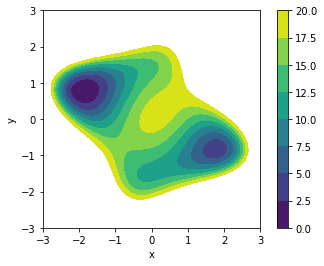

In [7]:
#some plotting functions
model2D = bg.ModifiedWolfeQuapp(2)
nbins = 101
x_bins = np.linspace(-3, 3, nbins)
y_bins = x_bins
XY = np.array(np.meshgrid(x_bins, y_bins))
DoubleWellXY = model2D.energy(torch.as_tensor(XY.T).reshape(nbins**2,2)).view(nbins, nbins).cpu().numpy().T

FES = np.zeros(len(x_bins))
for i in range(len(x_bins)):
    FES[i] = -np.logaddexp.reduce(-DoubleWellXY[:,i])
FES -= min(FES)

def plot_mueller(traj=None, traj2=None, grid=False):
    levels = np.linspace(0,20,9)
    
    plt.contourf(XY[0], XY[1], DoubleWellXY, levels)
    plt.colorbar()
    plt.gca().set_box_aspect(1)
    plt.xlabel('x')
    plt.ylabel('y')
    if grid:
        plt.grid(linestyle='dashed')
    if traj is not None:
        xy_samples = assert_numpy(traj).reshape(len(traj),-1)[:,:2]
        plt.plot(xy_samples[:,0], xy_samples[:,1], '.r')
    if traj2 is not None:
        xy_samples = assert_numpy(traj2).reshape(len(traj2),-1)[:,:2]
        plt.plot(xy_samples[:,0], xy_samples[:,1], '+m')
    plt.show()
    
def plot_fes(data, temp=1/kB, bins='auto', w=None, show=True):
    x_samples = assert_numpy(data)
    beta = 1/(temp*kB)
    FES_t = [-np.logaddexp.reduce(-beta*DoubleWellXY[:,i]) for i in range(len(x_bins))]
    FES_t -= min(FES_t)
    plt.plot(x_bins, FES_t, '--', label='reference')
    if w is not None and bins == 'auto':
        bins = 50
    hist, edges = np.histogram(x_samples, bins=bins, weights=w)
    fes_estimate = -np.log(np.where(hist!=0, hist/hist.max(), np.nan))
    xrange = edges[:-1]+(edges[1]-edges[0])/2
    plt.plot(xrange, fes_estimate, label='estimate')
    plt.xlabel('x')
    plt.ylabel('FES')
    plt.ylim(0, FES_t[-1])
    plt.xlim(x_bins[0], x_bins[-1])
    plt.legend()
    if show:
        plt.show()
    fes_estimate[np.isnan(fes_estimate)] = 1000
    
    print(f'ref DeltaF: {np.logaddexp.reduce(-FES_t[x_bins<0])-np.logaddexp.reduce(-FES_t[x_bins>0]):g} [kBT]')
    print(f'    DeltaF: {np.logaddexp.reduce(-fes_estimate[xrange<0])-np.logaddexp.reduce(-fes_estimate[xrange>0]):g} [kBT]')

plot_mueller()

## run MD

In [50]:
#setup the system
dim = 16 #2**12
n_temps = 4 #40
lowT = 1 / kB
highT = 5 / kB

model = bg.ModifiedWolfeQuapp(dim)
modelMD = WolfeQuappOpenMM(model)

modelMD.dim, modelMD.MD_dim - modelMD.dim

(16, 2)

In [51]:
%%time
#setup and equilibrate

pace = 100
n_equil = 200
temperatures = np.geomspace(lowT, highT, n_temps)

integrator = [openmm.LangevinMiddleIntegrator(lowT*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond)]
simulation = [openmm.app.Simulation(modelMD.topology, modelMD.system, integrator[-1])]
initial_pos = [modelMD.positions]
simulation[-1].context.setPositions(initial_pos[-1])
for temp in tqdm(temperatures[1:]):
    integrator.append(openmm.LangevinMiddleIntegrator(temp*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond))
    simulation.append(openmm.app.Simulation(modelMD.topology, modelMD.system, integrator[-1]))
    simulation[-1].context.setPositions(initial_pos[-1])
    simulation[-1].step(n_equil*pace)
    initial_pos.append(simulation[-1].context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers))
initial_pos = np.array(initial_pos)
print('Temperatures:', temperatures * kB)
print()

  0%|          | 0/3 [00:00<?, ?it/s]

Temperatures: [1.         1.70997595 2.92401774 5.        ]

CPU times: user 669 ms, sys: 356 ms, total: 1.02 s
Wall time: 1.1 s


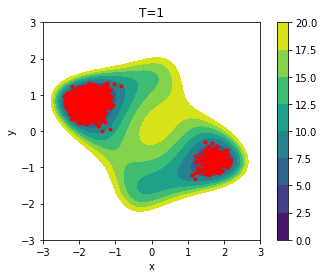

CPU times: user 2min 13s, sys: 27.4 s, total: 2min 41s
Wall time: 2min 8s


In [52]:
%%time
#sample 

pace = 100
n_iter = 10_000

is_swapped = np.full((n_temps,n_iter), False)
ener = np.full((n_temps, n_iter), np.nan)
data = np.full((n_temps, n_iter, 2), np.nan)
full_data = np.full((2, n_iter, *modelMD.positions.shape), np.nan)
for n in range(n_iter):
    for t in range(n_temps):
        simulation[t].step(pace)
        ener[t][n] = simulation[t].context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
        data[t][n] = np.array(simulation[t].context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers))[0,:2]
        if t == 0 or t == 1:
            full_data[t][n] = simulation[t].context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers)
    for tt in range(n%2, n_temps-1, 2):
        delta = -(1/(kB*temperatures[tt])-1/(kB*temperatures[tt+1]))*(ener[tt][n]-ener[tt+1][n])
        if delta <= 0.0 or np.random.rand() < np.exp(-delta):
            is_swapped[tt][n], is_swapped[tt+1][n] = True, True
            full_data_tt = simulation[tt].context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers)
            full_data_tt1 = simulation[tt+1].context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers)
            simulation[tt].context.setPositions(full_data_tt1)
            simulation[tt+1].context.setPositions(full_data_tt)
            simulation[tt].context.setVelocitiesToTemperature(temperatures[tt])
            simulation[tt+1].context.setVelocitiesToTemperature(temperatures[tt+1])
    if (n+1) % (n_iter//10) == 0:
        clear_output(wait=True)
        plt.title(f'T={kB*temperatures[0]:g}')
        plot_mueller(data[0][:n+1])
    print(f'sampling...  {(n+1)/n_iter:.1%}, accepted: {2*is_swapped[0].sum()/(n+1):.2%}', end='\r')

## check results

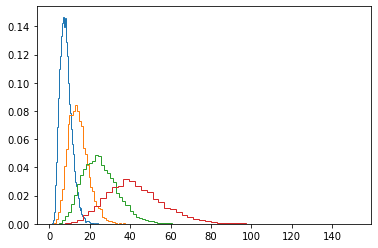

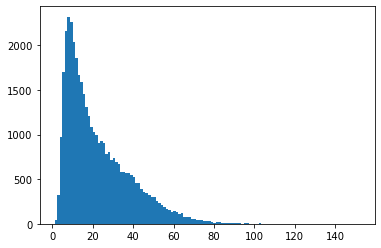

In [53]:
hist_opt = {'bins': 50, 'histtype': 'step', 'density': True}
for t in range(len(temperatures)):
    plt.hist(ener[t], **hist_opt, label=f'T={kB*temperatures[t]:g}')
# plt.legend()
plt.show()
plt.hist(ener.reshape(-1), bins='auto')
plt.show()

Acceptance rate: 27.70%
Useful exchanges: 9.819%


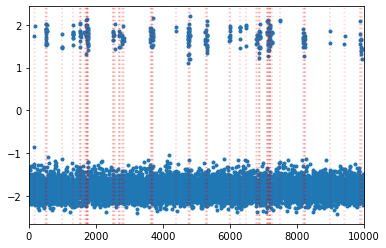

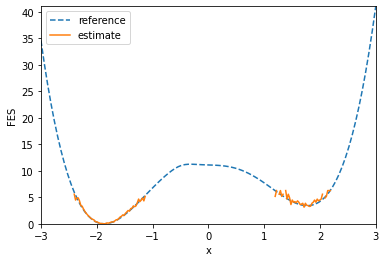

ref DeltaF: 3.31506 [kBT]
    DeltaF: 3.46925 [kBT]


In [54]:
print(f'Acceptance rate: {is_swapped[0].sum()/(n_iter//2):.2%}')
diff = np.array(data[0,:,0]*data[1,:,0] < 0)
print(f'Useful exchanges: {diff[is_swapped[0]].sum()/is_swapped[0].sum():.3%}')
plt.plot(data[0,:,0],'.')
for sw in np.where(is_swapped[0])[0]:
    if diff[sw]:
        plt.axvline(sw, c='r', ls=':', alpha=.1)
plt.xlim(0,n_iter)
plt.show()
plot_fes(data[0,:,0])

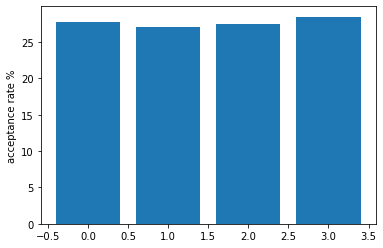

27.6625

In [55]:
adjust_rate = np.ones(n_temps) #first and last replica try half of the exchanges
adjust_rate[0], adjust_rate[-1] = 2, 2
plt.bar(np.arange(n_temps), adjust_rate*[sw.sum()/n_iter*100 for sw in is_swapped])
plt.ylabel('acceptance rate %')
plt.show()
np.mean(adjust_rate*[sw.sum()/n_iter*100 for sw in is_swapped])

In [56]:
# np.save(f'dw-REX-N{dim}', data[0,:,0])

## efficiency

In [57]:
efficiency = 1
for i in range(1,n_temps):
    logw = ener[i]/kB*(1/temperatures[i]-1/temperatures[0])
    efficiency += bg.effective_sample_size(torch.as_tensor(logw)).item()/len(logw)
print(f'neigh efficiency: {(efficiency-1):.2%}')
print(f'   tot efficiency: {efficiency/n_temps:.2%}')

neigh efficiency: 21.92%
   tot efficiency: 30.48%


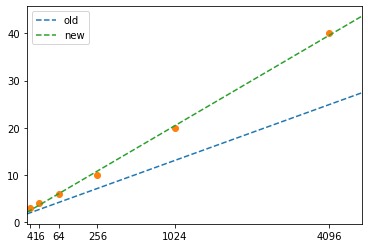

[4, 16, 64, 256, 1024, 4096]

In [22]:
#fitting
estimates = [   3,  4,   6,  10,  20, 40] #number of replicas
ESS_other = [45.2, 20, 9.6, 5.9, 5.5, 5.0] #including neighbor replicas
av_accept = [  37, 27,  20,  15,  18, 19] #average acceptance rate
av_useful = [  14, 10,  14,  16,   7,  3.6] #useful exchanges are a symptom of mixing quality
old_estimates = [2, 3, 4, 7, 13, 25]
dims = [2**i for i in range(2, 2*len(estimates)+1, 2)]
xrange = np.sqrt(np.linspace(2, 5000, 1000))

coef = np.polyfit(np.sqrt(dims), old_estimates, 1)
old_poly1d_fn = np.poly1d(coef)
coef = np.polyfit(np.sqrt(dims), estimates, 1)
poly1d_fn = np.poly1d(coef)
# print(coef)

plt.plot(xrange, old_poly1d_fn(xrange), '--', label='old')
plt.plot(np.sqrt(dims), estimates, 'o')
plt.plot(xrange, poly1d_fn(xrange), '--', label='new')
plt.xlim(xrange[0], xrange[-1])
plt.xticks(np.sqrt(dims), dims)
plt.legend()
plt.show()
dims

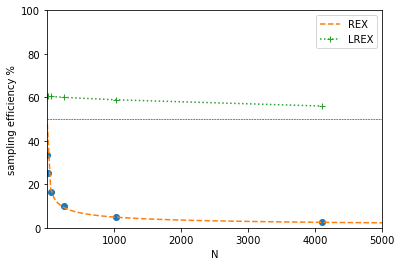

In [200]:
dims = [2**i for i in range(2, 2*len(estimates)+1, 2)]
ESS_measured = [20.93, 20.99, 20.80, 19.95, 17.73, 12.02]
xrange = np.linspace(2, 5000, 100)
plt.plot(dims, 100/np.array(estimates), 'o')
plt.plot(xrange, 100/poly1d_fn(np.sqrt(xrange)), '--', label='REX')
# plt.plot(dims, ESS_measured, 'x:')
plt.plot(dims, 100*(1+np.array(ESS_measured)/100)/2, '+:', label='LREX')
plt.axhline(50, c='k', ls='--', lw=0.5)
plt.xlim(xrange[0], xrange[-1])
plt.ylim(0,100)
plt.ylabel('sampling efficiency %')
plt.xlabel('N')
plt.legend()
plt.show()

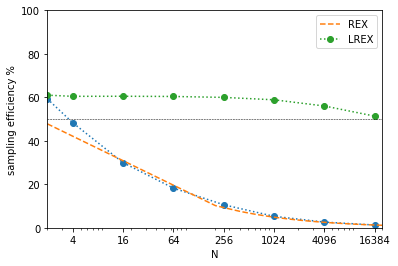

In [204]:
# dims = [2**i for i in range(2, 2*len(estimates)+1, 2)]
# ESS_measured = [20.93, 20.99, 20.80, 19.95, 17.73, 12.02]
xrange = np.linspace(2, 20_000, 100)
plt.plot([2,*dims], 100*(1+np.array([18.6,*ESS_other])/100)/np.array([2, *estimates]), 'o:')
plt.plot(xrange, 100/poly1d_fn(np.sqrt(xrange)), '--', label='REX')
# plt.plot(dims, ESS_measured, 'x:')
plt.plot([2,*dims], 100*(1+np.array([22,*ESS_measured])/100)/2, 'o:', label='LREX')
# plt.plot([2,*dims], 100*(1+np.array([22,*ESS_measured])/100)/2.5, 'x:', label='LREX + training')
plt.axhline(50, c='k', ls='--', lw=0.5)
plt.xlim(xrange[0], xrange[-1])
plt.ylabel('sampling efficiency %')
plt.xlabel('N')
# plt.xticks([2**i for i in range(1, 2*len(estimates)+1, 1)])
plt.xscale('log')
plt.xticks(dims, dims)
plt.ylim(0,100)
plt.legend()
plt.show()

In [202]:
dims = [*dims, 2**14]
estimates = [*estimates, 78]
ESS_measured = [*ESS_measured, 2.67]
ESS_other = [*ESS_other, 0]